In [1]:
%load_ext autoreload
%autoreload 2


cosmap
tensor([0.6367, 0.7073, 0.7845, 0.8674, 0.9537, 1.0400, 1.1212, 1.1908, 1.2423,
        1.2697, 1.2697, 1.2422, 1.1907, 1.1210, 1.0399, 0.9536, 0.8672, 0.7844,
        0.7071, 0.6366])


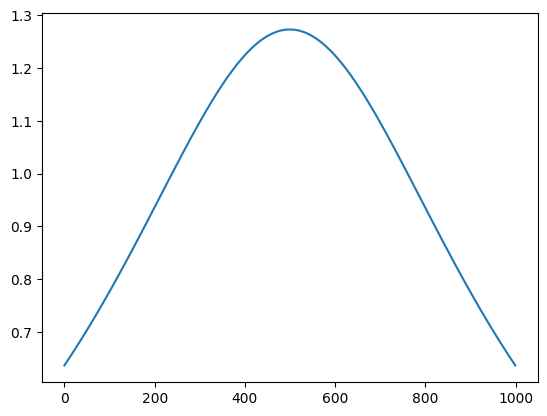

In [3]:
from diffusers.training_utils import compute_loss_weighting_for_sd3
import torch
import matplotlib.pyplot as plt


for schema in [#'sigma_sqrt',
     'cosmap']:
    print(schema)
    print(compute_loss_weighting_for_sd3(weighting_scheme=schema, sigmas=torch.linspace(0.0001, 1, 20)))
    _ = plt.plot(compute_loss_weighting_for_sd3(weighting_scheme=schema, sigmas=torch.linspace(0.0001, 1, 1000)))



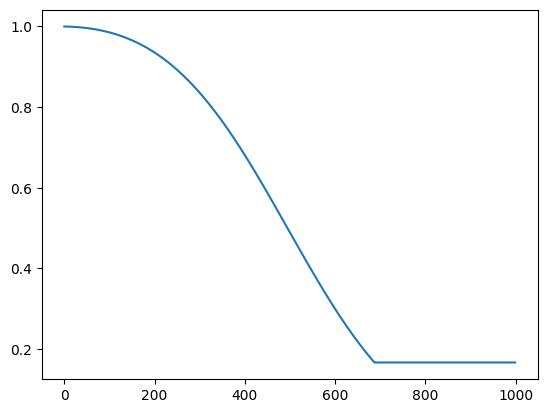

In [13]:
def compute_flow_matching_min_snr_weights(t, min_snr_gamma):
        """
        Compute min-SNR(gamma) weighting from timesteps.

        For flow-matching, SNR(t) ≈ t²/(1-t)² based on the interpolation schedule.
        We clip this to prevent extreme weights at t→0 or t→1.

        Args:
            t: Timesteps [B]

        Returns:
            Weights [B]
        """
        # Avoid division by zero at boundaries
        t_clamped = torch.clamp(t, min=1e-5, max=1 - 1e-5)

        # Compute SNR for flow-matching interpolation
        # SNR(t) = signal²/noise² = t²/(1-t)²
        snr = (t_clamped ** 2) / ((1 - t_clamped) ** 2)

        # Apply min-SNR clipping
        snr_capped = torch.minimum(snr, torch.tensor(min_snr_gamma))

        # Weight is inverse of capped SNR (higher weight for harder timesteps)
        # Add 1 to prevent division issues when snr=0
        weights = 1.0 / (snr_capped + 1.0)

        return weights

_ = plt.plot(compute_flow_matching_min_snr_weights(t=torch.linspace(0.01, 1, 1000), min_snr_gamma=5))


In [2]:
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained('/workspace/models/sdsf-97k-1e5qrt-12k-4e6sqrt-11k-h')
pipe.to('cuda')

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.32.2",
  "_name_or_path": "/workspace/models/sdsf-97k-1e5qrt-12k-4e6sqrt-11k-h",
  "feature_extractor": [
    null,
    null
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": null,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "DDIMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [20]:
from diffusers import UNet2DConditionModel
import torch
encoder_hidden_states = torch.randn((1, 77, 1024), device=pipe.device)
sample = torch.randn((1, 4, 64, 64), device=pipe.device)
t = 1
torch.set_grad_enabled(False)
unet: UNet2DConditionModel = pipe.unet
unet.forward(sample, t, encoder_hidden_states)

UNet2DConditionOutput(sample=tensor([[[[-0.0026, -0.0861, -0.0305,  ..., -0.0252, -0.1141, -0.1871],
          [-0.2684,  0.0682, -0.1958,  ...,  0.0908, -0.0617,  0.2933],
          [ 0.2780,  0.0869,  0.0343,  ..., -0.0701, -0.2091,  0.1252],
          ...,
          [ 0.0185, -0.1049,  0.2676,  ...,  0.1723,  0.2476,  0.5632],
          [ 0.1645, -0.2126, -0.2057,  ..., -0.0940,  0.1235, -0.5113],
          [ 0.0458,  0.0271,  0.4546,  ...,  0.1276, -0.1022,  0.3144]],

         [[ 0.0397,  0.0903, -0.0054,  ..., -0.0137,  0.0799,  0.0875],
          [-0.1911,  0.0445, -0.0954,  ...,  0.0199, -0.1788,  0.0509],
          [ 0.0191, -0.0459,  0.0024,  ..., -0.0354, -0.0126,  0.1015],
          ...,
          [-0.0417, -0.0408,  0.2016,  ...,  0.1752, -0.0786, -0.1834],
          [ 0.1116, -0.0953,  0.0247,  ...,  0.0861,  0.1151,  0.1618],
          [-0.1573, -0.2601,  0.2365,  ..., -0.0889, -0.0833,  0.0491]],

         [[ 0.1022, -0.0431, -0.1588,  ...,  0.0374, -0.1128, -0.0384],
 

In [28]:
from diffusers import FlowMatchEulerDiscreteScheduler, DDPMScheduler

ddpm_scheduler = DDPMScheduler()
ddpm_scheduler.alphas_cumprod


tensor([9.9990e-01, 9.9978e-01, 9.9964e-01, 9.9948e-01, 9.9930e-01, 9.9910e-01,
        9.9888e-01, 9.9864e-01, 9.9838e-01, 9.9811e-01, 9.9781e-01, 9.9749e-01,
        9.9715e-01, 9.9679e-01, 9.9641e-01, 9.9602e-01, 9.9560e-01, 9.9516e-01,
        9.9471e-01, 9.9423e-01, 9.9374e-01, 9.9322e-01, 9.9269e-01, 9.9213e-01,
        9.9156e-01, 9.9097e-01, 9.9035e-01, 9.8972e-01, 9.8907e-01, 9.8840e-01,
        9.8771e-01, 9.8700e-01, 9.8627e-01, 9.8553e-01, 9.8476e-01, 9.8398e-01,
        9.8317e-01, 9.8235e-01, 9.8151e-01, 9.8065e-01, 9.7977e-01, 9.7887e-01,
        9.7795e-01, 9.7702e-01, 9.7606e-01, 9.7509e-01, 9.7410e-01, 9.7309e-01,
        9.7206e-01, 9.7102e-01, 9.6995e-01, 9.6887e-01, 9.6777e-01, 9.6665e-01,
        9.6551e-01, 9.6436e-01, 9.6319e-01, 9.6200e-01, 9.6079e-01, 9.5956e-01,
        9.5832e-01, 9.5706e-01, 9.5578e-01, 9.5449e-01, 9.5318e-01, 9.5185e-01,
        9.5050e-01, 9.4914e-01, 9.4776e-01, 9.4636e-01, 9.4494e-01, 9.4351e-01,
        9.4207e-01, 9.4060e-01, 9.3912e-

In [30]:
flow_match_scheduler = FlowMatchEulerDiscreteScheduler()
flow_match_scheduler.sigmas


tensor([1.0000, 0.9990, 0.9980, 0.9970, 0.9960, 0.9950, 0.9940, 0.9930, 0.9920,
        0.9910, 0.9900, 0.9890, 0.9880, 0.9870, 0.9860, 0.9850, 0.9840, 0.9830,
        0.9820, 0.9810, 0.9800, 0.9790, 0.9780, 0.9770, 0.9760, 0.9750, 0.9740,
        0.9730, 0.9720, 0.9710, 0.9700, 0.9690, 0.9680, 0.9670, 0.9660, 0.9650,
        0.9640, 0.9630, 0.9620, 0.9610, 0.9600, 0.9590, 0.9580, 0.9570, 0.9560,
        0.9550, 0.9540, 0.9530, 0.9520, 0.9510, 0.9500, 0.9490, 0.9480, 0.9470,
        0.9460, 0.9450, 0.9440, 0.9430, 0.9420, 0.9410, 0.9400, 0.9390, 0.9380,
        0.9370, 0.9360, 0.9350, 0.9340, 0.9330, 0.9320, 0.9310, 0.9300, 0.9290,
        0.9280, 0.9270, 0.9260, 0.9250, 0.9240, 0.9230, 0.9220, 0.9210, 0.9200,
        0.9190, 0.9180, 0.9170, 0.9160, 0.9150, 0.9140, 0.9130, 0.9120, 0.9110,
        0.9100, 0.9090, 0.9080, 0.9070, 0.9060, 0.9050, 0.9040, 0.9030, 0.9020,
        0.9010, 0.9000, 0.8990, 0.8980, 0.8970, 0.8960, 0.8950, 0.8940, 0.8930,
        0.8920, 0.8910, 0.8900, 0.8890, 

In [36]:
flow_match_scheduler.set_timesteps(num_inference_steps=999)

In [37]:
flow_match_scheduler.sigmas

tensor([1.0000, 0.9990, 0.9980, 0.9970, 0.9960, 0.9950, 0.9940, 0.9930, 0.9920,
        0.9910, 0.9900, 0.9890, 0.9880, 0.9870, 0.9860, 0.9850, 0.9840, 0.9830,
        0.9820, 0.9810, 0.9800, 0.9790, 0.9780, 0.9770, 0.9760, 0.9750, 0.9740,
        0.9730, 0.9720, 0.9710, 0.9700, 0.9690, 0.9680, 0.9670, 0.9660, 0.9650,
        0.9640, 0.9630, 0.9620, 0.9610, 0.9600, 0.9590, 0.9580, 0.9570, 0.9560,
        0.9550, 0.9540, 0.9530, 0.9520, 0.9510, 0.9499, 0.9489, 0.9479, 0.9469,
        0.9459, 0.9449, 0.9439, 0.9429, 0.9419, 0.9409, 0.9399, 0.9389, 0.9379,
        0.9369, 0.9359, 0.9349, 0.9339, 0.9329, 0.9319, 0.9309, 0.9299, 0.9289,
        0.9279, 0.9269, 0.9259, 0.9249, 0.9239, 0.9229, 0.9219, 0.9209, 0.9199,
        0.9189, 0.9179, 0.9169, 0.9159, 0.9149, 0.9139, 0.9129, 0.9119, 0.9109,
        0.9099, 0.9089, 0.9079, 0.9069, 0.9059, 0.9049, 0.9039, 0.9029, 0.9019,
        0.9009, 0.8999, 0.8989, 0.8979, 0.8969, 0.8959, 0.8949, 0.8939, 0.8929,
        0.8919, 0.8909, 0.8899, 0.8889, 

In [38]:
flow_match_scheduler.config.num_train_timesteps

1000

In [5]:
import torch
from flow_match_model import TrainFlowMatchScheduler

fm_test = TrainFlowMatchScheduler()
latents = torch.zeros((2, 2, 4, 4))
noise = torch.randn((2, 2, 4, 4))
timesteps = torch.tensor([25, 800]).float()
fm_test.add_noise(latents, noise=noise, timesteps=timesteps)

tensor([[[[ 1.7255e-03,  3.6151e-02,  2.4916e-02, -1.6366e-02],
          [-1.6807e-02,  3.6365e-02,  7.2999e-03,  2.1796e-02],
          [ 1.5282e-02,  1.1898e-02,  4.7807e-02,  2.1460e-03],
          [ 2.3789e-03, -3.0880e-02, -1.2320e-02,  1.8212e-02]],

         [[ 1.2401e-02,  2.1128e-02, -2.2245e-02,  6.8282e-03],
          [-8.3879e-04, -2.9115e-02, -1.2566e-02,  1.5880e-02],
          [ 2.3336e-03,  1.7620e-03,  1.3792e-02,  5.8069e-02],
          [ 2.7562e-02,  3.2397e-02, -6.5625e-04, -3.7049e-03]]],


        [[[ 5.0220e-01,  4.6862e-01, -2.8391e-01,  1.5828e+00],
          [ 4.6378e-01, -4.9399e-01, -5.2750e-01,  1.6655e-01],
          [-1.1746e-01,  2.6590e-01, -3.8549e-01,  8.1833e-01],
          [ 1.3708e+00, -1.1354e+00, -5.0093e-01, -8.4668e-02]],

         [[ 2.0360e-01,  1.9414e+00,  1.1909e+00,  9.5778e-03],
          [-9.0992e-01, -1.1448e+00,  1.5024e-01,  5.7546e-01],
          [ 2.5659e-01,  6.6680e-01, -7.3046e-01, -7.1683e-01],
          [ 4.8257e-02, -1.3499e

In [4]:
from diffusers import FlowMatchEulerDiscreteScheduler

scheduler = FlowMatchEulerDiscreteScheduler.from_config(pipe.scheduler.config)

The config attributes {'skip_prk_steps': True} were passed to FlowMatchEulerDiscreteScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


In [5]:
pipe.scheduler = scheduler

pipe.to('cuda')

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.32.2",
  "_name_or_path": "/workspace/models/sdsf-97k-1e5qrt-12k-4e6sqrt-11k-h",
  "feature_extractor": [
    null,
    null
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": null,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "FlowMatchEulerDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [22]:
prompt = "A cat in a forest"
pipe: StableDiffusionPipeline
pipe.scheduler.init_noise_sigma = 1
pipe.scheduler.scale_model_input = lambda x, t: x
images = pipe(prompt=prompt, negative_prompt="ugly, pointillism", height=768, width=768, num_inference_steps=30)    


  0%|          | 0/30 [00:00<?, ?it/s]

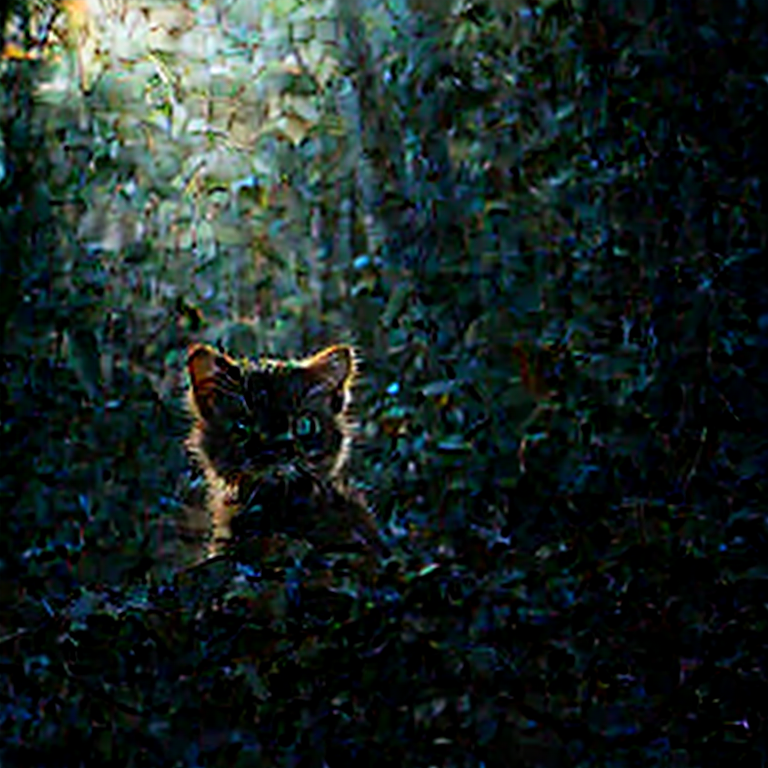

In [23]:
images.images[0]